In [1]:
import xml.etree.ElementTree
from os import listdir
from os.path import join
import functools
import random
import pickle as pkl
import matplotlib.pyplot as plt

WORK_DIR = "../Data/bioc-FH-training/"
# PROCESSED_DIR = "../Data/processed/"
OBJECTS_DIR = '../objects/'

In [2]:
# get all data file names
file_list  = listdir(WORK_DIR)
file_names = set()

for file in file_list:
    if file != '' and file.endswith('txt'):
        file_names.add(file.split('.')[0])

assert(len(file_names) == 99)

In [3]:
# get corrected entities with format
# (start_posi, end_posi, type, content, id_in_xml)
with open(join(OBJECTS_DIR, 'entities_corrected.pkl'), 'rb') as f:
    entities = pkl.load(f)
print(entities['doc_97'])

[(329, 349, 'FamilyMember', 'Maternal grandfather', '33'), (378, 398, 'FamilyMember', 'Maternal grandmother', '35'), (435, 441, 'FamilyMember', 'Mother', '14'), (458, 474, 'Observation', 'severe nosebleed', '15'), (479, 490, 'Observation', 'thalassemia', '16'), (552, 565, 'FamilyMember', 'Maternal aunt', '37'), (595, 610, 'FamilyMember', 'Maternal uncles', '38'), (622, 636, 'Observation', 'stomach cancer', '19'), (641, 655, 'Observation', 'hypothyroidism', '20'), (680, 702, 'FamilyMember', 'maternal first cousins', '40'), (726, 746, 'FamilyMember', 'Paternal grandfather', '41'), (766, 781, 'Observation', 'type 2 diabetes', '42'), (812, 832, 'FamilyMember', 'Paternal grandmother', '43'), (857, 888, 'Observation', 'esophago pharyngeal diverticula', '23'), (897, 905, 'Observation', 'fainting', '22'), (908, 914, 'FamilyMember', 'Father', '24'), (935, 951, 'Observation', 'larynx carcinoma', '25'), (1013, 1018, 'FamilyMember', 'uncle', '6'), (1063, 1069, 'FamilyMember', 'cousin', '9'), (1091

In [4]:
with open(join(OBJECTS_DIR, 'sents.pkl'), 'rb') as f:
    sents = pkl.load(f)

# Get relation chains from annotated xml files

In [5]:
def get_entity(entities, id):
    for entity in entities:
        if entity[4] == id:
            return entity
    return None

In [6]:
entity_pairs = {}
negative_pairs = {}

for file_name in file_names:
    file_path = WORK_DIR + file_name + '.xml'
    root = xml.etree.ElementTree.parse(file_path).getroot()
    annotations = root.findall('annotations')[0]

    for relation in annotations.findall('relation'):
        properties = relation.find('properties')
        fm_id = properties.find('FamilyMembers').text
        
        if not fm_id: # FamilyMembers is empty
            continue
        else:
            fm = get_entity(entities[file_name], fm_id)
        
        for property_ in properties.findall('Properties'):
            for entity in entities[file_name]:
                if entity[4] == property_.text and entity[2] == 'Observation':
                    entity_pair = (fm[0], fm[1], entity[0], entity[1], 'FM-OBS')
                    entity_pairs[file_name] = entity_pairs.get(file_name, []) + [entity_pair]
                else:
                    negative_pair = (fm[0], fm[1], entity[0], entity[1], 'OTHERS')
                    negative_pairs[file_name] = negative_pairs.get(file_name, []) + [negative_pair]
print(entity_pairs['doc_97'])

[(435, 441, 458, 474, 'FM-OBS'), (435, 441, 479, 490, 'FM-OBS'), (908, 914, 935, 951, 'FM-OBS'), (1091, 1099, 1121, 1129, 'FM-OBS'), (1091, 1099, 1138, 1159, 'FM-OBS'), (1091, 1099, 1184, 1205, 'FM-OBS'), (595, 610, 622, 636, 'FM-OBS'), (595, 610, 641, 655, 'FM-OBS'), (726, 746, 766, 781, 'FM-OBS'), (812, 832, 857, 888, 'FM-OBS'), (812, 832, 897, 905, 'FM-OBS')]


# Generating positive training data
Concate the two sentences where FM and OBS are in

In [7]:
def get_sent(sents, span_end):
    span = 0
    for sent_id, sent in enumerate(sents):
        span += len(sent)
        if span >= span_end:
            return sent_id, sent
    return None

In [8]:
def entity_pairs2data(doc, ent_pairs, single_sent, diff, data):
    for _, ent1_end, _, ent2_end, label in ent_pairs:
        sent1 = get_sent(sents[doc], ent1_end)
        sent2 = get_sent(sents[doc], ent2_end)
        if sent1 and sent2:
            if sent1[0] != sent2[0]:
                # instance: ([sent_ids], sent1, sent2, label)
                instance = ([doc, sent1[0], sent2[0]], sent1[1], sent2[1], label)
                diff.insert(0, abs(sent2[0]-sent1[0]))
            else:
                single_sent += 1
                instance = ([doc, sent1[0]], sent1[1], label)
            data[doc] = data.get(doc, []) + [instance]
    return single_sent, diff, data

In [9]:
positive_data = {}
diff, single_sent = [], 0

for doc, ent_pairs in entity_pairs.items():
    single_sent, diff, positive_data = entity_pairs2data(doc,
                                                         ent_pairs,
                                                         single_sent,
                                                         diff,
                                                         positive_data)
positive_data['doc_97'][0]

(['doc_97', 6],
 'Mother (II.4) has some severe nosebleed and thalassemia as a child but nothing unusual.',
 'FM-OBS')

In single sent: 307 , across sents: 440


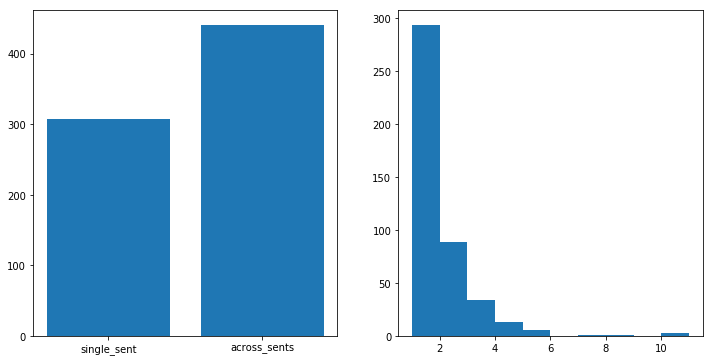

In [10]:
print("In single sent:", single_sent, ", across sents:", len(diff))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [single_sent, len(diff)]
axs[0].bar(names, values)

axs[1].hist(diff)

plt.show()

# Generating negative training data

In [11]:
neg_candidates = sum(map(len, negative_pairs.values()))
len_posi = single_sent + len(diff)
negative_data = {}

neg_single_sent, neg_diff = 0, []

for doc, ent_pairs in negative_pairs.items():
    num_to_gen = round(len(ent_pairs) / neg_candidates * len_posi)
    # TODO: adjust picked pairs ratio
    picked_pairs = random.sample(ent_pairs, num_to_gen)
    
    neg_single_sent, neg_diff, negative_data = entity_pairs2data(doc,
                                                                 picked_pairs,
                                                                 neg_single_sent,
                                                                 neg_diff,
                                                                 negative_data)
negative_data['doc_97'][0]

(['doc_97', 4, 14],
 'Maternal grandfather (I.2), age 84, is healthy.',
 'Father (II.6), age 51, had larynx carcinoma as a child but nothing out of the range of normal.',
 'OTHERS')

For negative data:
In single sent: 67 , across sents: 674


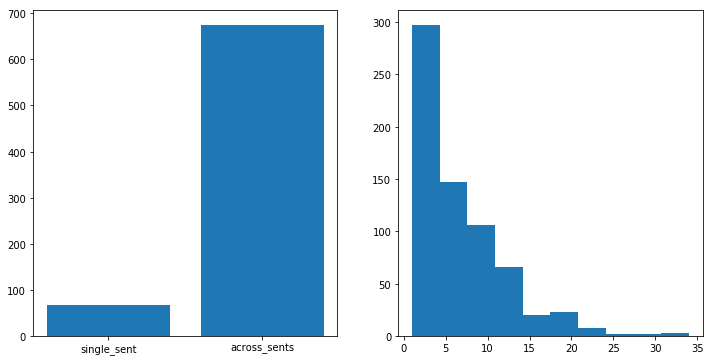

In [12]:
print("For negative data:\nIn single sent:", neg_single_sent, ", across sents:", len(neg_diff))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

names = ['single_sent', 'across_sents']
values = [neg_single_sent, len(neg_diff)]
axs[0].bar(names, values)

axs[1].hist(neg_diff)

plt.show()

# shuffling and split data

In [13]:
data = []
for doc, posi in positive_data.items():
    try:
        data += posi + negative_data[doc]
    except KeyError:
        pass
random.shuffle(data)

In [14]:
amount = len(data)
train_ratio = 0.8
validation = 1 - train_ratio

data = {'train': data[:int(train_ratio*amount)], 'valid': data[int(train_ratio*amount):]}
with open(join(OBJECTS_DIR, 're_data.pkl'), 'wb') as f:
    pkl.dump(data, f)

In [15]:
def write_data(data, file):
    f = open(join(OBJECTS_DIR, file), 'w')
    
    for item in data:
        if len(item[0]) < 3:  # single_sent
            # content: [id, sent1, sent2, label]
            content = ["_".join(map(str, item[0])), item[1], item[1], item[-1]]
        else:
            content = ["_".join(map(str, item[0])), item[1], item[2], item[-1]]
        f.write('\t'.join(content) + '\n')
        
    f.close()

write_data(data['train'], 're_train_data.txt')
write_data(data['valid'], 're_valid_data.txt')